# Deep Q-Learning (DQN)
In this tutorial, we will implement DQN in the Mountain Car environment that you should know...
**Now we are not in table RL anymore, we deal with continuous spaces !**

## Imports and Utils
Don't pay attention to this part

In [21]:
import math, random, os

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [22]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
import imageio
from PIL import Image as PILImage
from IPython.display import Image
# Define the directory to save the GIF
gif_dir = '/content/drive/MyDrive/gifs'  # Replace with your desired directory
os.makedirs(gif_dir, exist_ok=True)

# Function to run an episode and save as GIF
def run_and_save_gif(model, env, episode_length=200):
    images = []
    state = env.reset()
    total_reward = 0

    for step in range(episode_length):
        epsilon = 0.01  # Set a low epsilon for demonstration
        action = model.act(state, epsilon)

        if isinstance(action, torch.Tensor):
            action = action.item()
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Render the environment and append the image as a NumPy array
        img = env.render(mode='rgb_array')
        images.append(PILImage.fromarray(img))  # Explicitly use PILImage
        state = next_state
        if done:
            break

    gif_filename = os.path.join(gif_dir, f"episode_{len(os.listdir(gif_dir))}.gif")
    imageio.mimsave(gif_filename, images, fps=30)  # Adjust fps as needed
    print(f"GIF saved to: {gif_filename}")
    print(f"Total reward: {total_reward}")

    return gif_filename


In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Mountain Car Environment

A car is on a one-dimensional track, positioned between two "mountains".<br>
The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass.<br>
Therefore, the only way to succeed is to drive back and forth to build up momentum.

<img align="Left" src="https://www.gymlibrary.dev/_images/mountain_car.gif" width = 40% >

In [35]:
env_id = "MountainCar-v0"
env = gym.make(env_id)


**-> print State and action spaces**

In [36]:
print("Observation (State) Space: ", env.observation_space)
print("Action Space: ", env.action_space)
print("Observation Space - Low:", env.observation_space.low)
print("Observation Space - High:", env.observation_space.high)
print("Number of Actions:", env.action_space.n)


Observation (State) Space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space:  Discrete(3)
Observation Space - Low: [-1.2  -0.07]
Observation Space - High: [0.6  0.07]
Number of Actions: 3


# Implementing DQN

## Creating the Replay Buffer

DQNs tend to “forget” certain $(s,a)=r$ situations it encountered in the past (kinda like catastrophic forgetting).

Whole __experience replay__ idead is tp maintain a buffer of the old experiences and train it again on them.

In [37]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity, device=torch.device("cpu")):
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

## Epsilon greedy exploration

Greedy and Epsilon Greedy exploration methods are fairly easy to understand and to implement, but they suffer from major setback which is they have sub-optimal regret. As a matter of fact the regret of both Greedy and Epsilon Greedy grows linearly by the time.

This is easy to intuitively understand, as the Greedy will lock on one action that happened to have good results at one point of time but it is not in reality the optimal action. So Greedy will keep exploiting this action while ignoring the others which might be better. It Exploits too much.

The Epsilon Greedy on the other hand, explores too much because even when one action seem to be the optimal one, the methods keeps allocating a fixed percentage of the time for exploration.

Conversely the decaying Epsilon Greedy methods, tries to decrease the percentage dedicated for exploration as time goes by.<br>
Exploration probability is shown in the graph below.

In [38]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx):
    return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

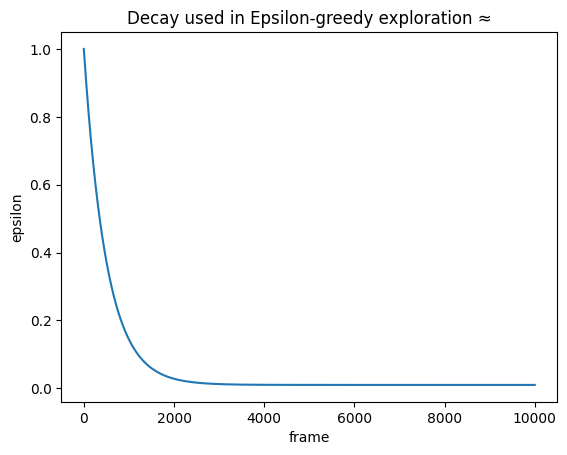

In [39]:
plt.title('Decay used in Epsilon-greedy exploration ≈')
plt.xlabel('frame')
plt.ylabel('epsilon')
plt.plot([epsilon_by_frame(i) for i in range(10000)])


## Deep Q-Network

Our DQN model is a feed forward neural network, trained with a variant of Q-learning. It was first applied to seven Atari 2600 games from the Arcade Learning Environment, with no adjustment of the architecture or learning algorithm.
In the Paper they write:
> "We instead use an architecture
in which there is a separate output unit for each possible action, and **only the state representation is
an input to the neural network**. The outputs correspond to the predicted Q-values of the individual
action for the input state. The main advantage of this type of architecture is the ability to compute
Q-values for all possible actions in a given state with only a single forward pass through the network."

For more info we suggest reading the original DeepMind paper https://arxiv.org/pdf/1312.5602

**-> Implement a NN with nn.Sequential that will be our Q network, use 3 Linear layers with 128 Neurons**, *be careful of the input / outputs  dimensions !*

**-> Complete the `act()` function to implement Eps-greedy policy**

In [40]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.num_actions = num_actions

        ##################
        # Implémentation du réseau Q avec nn.Sequential
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        ##################

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        """
        Given a state, take an epsilon-greedy action.
        Args:
          state: a state from the environment
          epsilon: the probability of choosing a random action
        Returns:
          action (int): the action to take
        """
        rand_float = random.random()  # Génère un nombre aléatoire entre 0 et 1

        ##################
        if rand_float < epsilon:
            # Prendre une action aléatoire
            action = random.randint(0, self.num_actions - 1)
        else:
            # Prendre l'action correspondant à l'argmax des Q-values
            state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Convertir l'état en tenseur
            q_values = self.forward(state)  # Obtenir les Q-values du réseau
            action = q_values.argmax(dim=1).item()  # Extraire l'indice de l'action optimale
        ##################
        return action


## Training


### Instanciate The Model

In [41]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
model = model.to(device)

optimizer = optim.Adam(model.parameters())
# Create Replay buffer for our model
replay_buffer = ReplayBuffer(capacity=1000)

GIF saved to: /content/drive/MyDrive/gifs/episode_2.gif
Total reward: -200.0


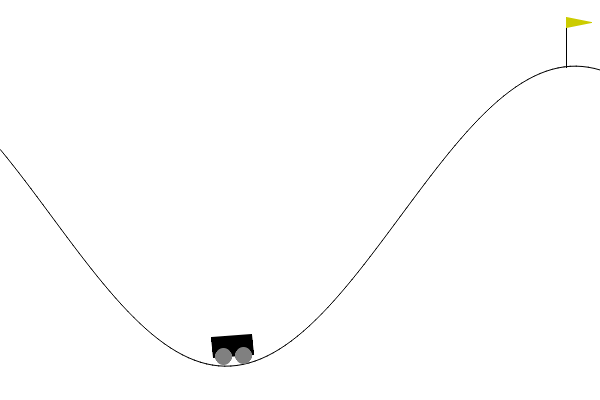

In [42]:
fileName = run_and_save_gif(model, env)
# Display the GIF using IPython.display.Image
Image(filename=fileName )

### Temporal Difference Loss
To Train our DQN, we will use an hybrid algorithm:

We optimize our parameters so that we obtain the best possible Q value. The Loss is computed as $$ \mathcal L = (\hat Q_t - \hat Q_{t+1})^2$$

**-> Compute the loss in the given function**

**-> Are we doing TD (Bootstrapping) or Monte Carlo ?**

In [43]:
def compute_td_loss(batch_size):
    """ Computes the Temporal Difference Loss and backpropagates the gradients """
    # Sample a batch from the replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to PyTorch tensors
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    # Compute Q-values for the current state
    q_values = model(state)  # Q(s, a) for all actions
    next_q_values = model(next_state)  # Q(s', a') for all actions

    # Select the Q-value corresponding to the chosen action
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    # Compute the maximum Q-value for the next state
    next_q_value = next_q_values.max(1)[0]

    # Compute the expected Q-value (target) using the Bellman equation
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    # Compute the loss (Mean Squared Error between predicted and expected Q-values)
    loss = nn.MSELoss()(q_value, expected_q_value.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [44]:
def plot(frame_idx, rewards, losses, env):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('environment')
    plt.imshow(env.render(mode='rgb_array'))

    plt.show()

### Training Loop
Now we have everything needed to train our DQN !

**-> Complete the training loop and train your DQN model with the given hyperparamters, Comment**

In [45]:
state = env.reset()

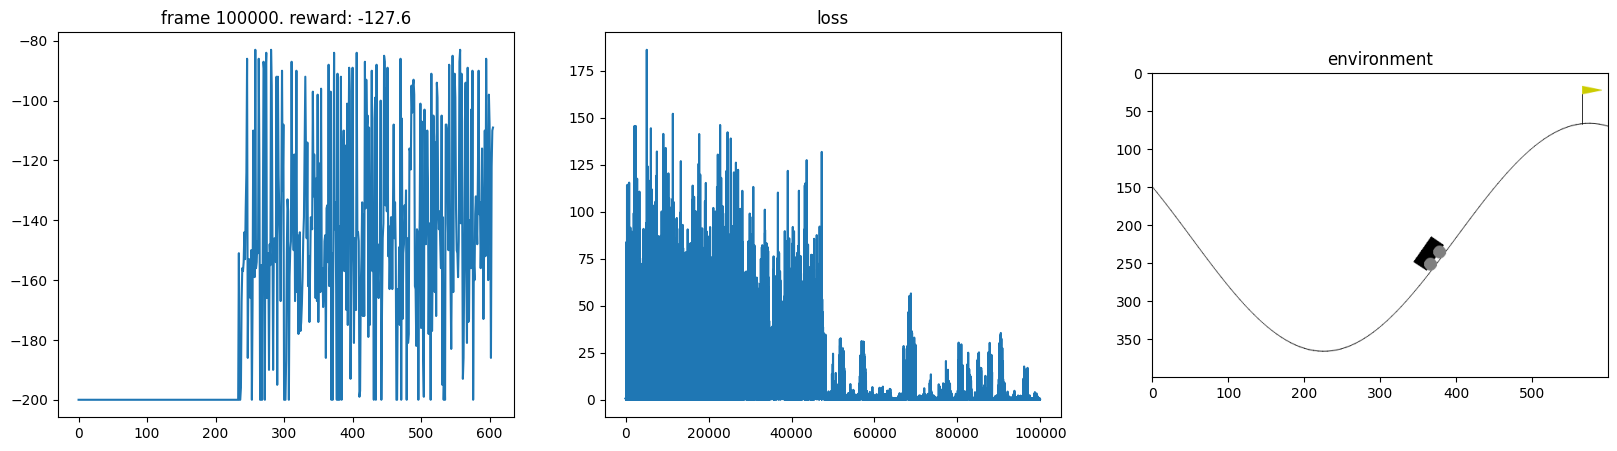

Training complete!


In [46]:
do_training = True

if do_training:
    # Hyperparameters
    num_frames = 100000
    batch_size = 64
    gamma = 0.99
    plot_every = 1000

    # Variables for tracking performance
    losses = []
    all_rewards = []
    episode_reward = 0

    # Initialize state
    state = env.reset()

    for frame_idx in range(1, num_frames + 1):
        # Compute epsilon for the epsilon-greedy policy
        epsilon = epsilon_by_frame(frame_idx)  # Use the epsilon decay function defined earlier

        # Take an action based on epsilon-greedy strategy
        action = model.act(state, epsilon)  # Use the model's `act` method to choose an action

        if isinstance(action, torch.Tensor):
            action = action.item()  # Convert action to a Python integer if necessary

        # Interact with the environment
        next_state, reward, done, _ = env.step(action)

        # Store the transition in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Update the state and reward tracker
        state = next_state
        episode_reward += reward

        # Reset the environment if the episode ends
        if done:
            state = env.reset()  # Reset the environment for the next episode
            all_rewards.append(episode_reward)  # Store the total reward of this episode
            episode_reward = 0  # Reset the episode reward

        # Train the model if the replay buffer has enough samples
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)  # Compute the Temporal Difference Loss
            losses.append(loss.data.item())  # Track the loss for plotting

        # Plot the rewards and losses periodically
        if frame_idx % plot_every == 0:
            plot(frame_idx, all_rewards, losses, env)

    print("Training complete!")


## Visualizing Trained Policy

GIF saved to: /content/drive/MyDrive/gifs/episode_3.gif
Total reward: -192.0


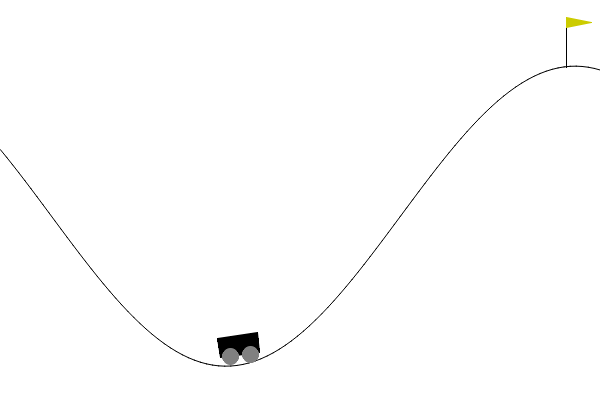

In [47]:
fileName = run_and_save_gif(model, env)
# Display the GIF using IPython.display.Image
Image(filename=fileName )

# Next steps?,

Now you can
* Consider using larger DQN architectures.
* Try to train faster, with more/less exploration ? With different decay ?
* Play around with actual Atari environments https://gym.openai.com/envs/#atari.
* Explore more DQN tricks https://drive.google.com/file/d/0BxXI_RttTZAhVUhpbDhiSUFFNjg/view.